In [1]:
import os
import pandas as pd
from utils.metrics import get_model_metrics
from utils.data_loader import *
from track2_mult_stage_utils import *
import numpy as np
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import seaborn as sns
from utils.utils import set_seed
import random
import math

LGBM Version 3.3.2
catboost Version 1.0.4
xgboost Version 1.5.1


## Get features

In [2]:
problem_ids = [1,   3,   5,  12,  13,  17,  20,  21,  22,  24,  25,  28,  31,
               32,  33,  34,  36,  37,  38,  39,  40, 100, 101, 102, 128, 232,
               233, 234, 235, 236]

In [3]:
train_data_dir = "data/csedm_2021/datashop/F19_Release_Train_06-28-21/Train/"
early,late,main_table,code_state,subject,metadata = load_raw_data(train_data_dir)
main_table = main_table[main_table['ProblemID'].isin(problem_ids)]
main_table['ProblemID'].unique().size

30

In [4]:
que_info_dict = json.load(open('data/csedm_2021/que_info_dict.json'))
concept_list = json.load(open('data/csedm_2021/concept_list.json'))
len(concept_list)

18

In [5]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
label_scaler = MinMaxScaler()
label_scaler.fit(subject['X-Grade'].values.reshape(-1, 1))
subject['X-Grade_norm'] = label_scaler.transform(
    subject['X-Grade'].values.reshape(-1, 1))
subject_2_score = dict(zip(subject['SubjectID'],subject['X-Grade']))

In [6]:
def get_list_feature(x, col_name):
    features = []
    feature_cols = []
    for fuc_name in ['mean', 'std', 'median', 'max', 'min']:
        value = eval(f"np.{fuc_name}(x)")
        feature_col = f"{col_name}_{fuc_name}"
        features.append(value)
        feature_cols.append(feature_col)

    for p in [25, 50, 75]:
        value = eval(f"np.percentile(x,{p})")
        feature_col = f"{col_name}_percentile_{p}"
        features.append(value)
        feature_cols.append(feature_col)
    return features, feature_cols

In [7]:
def padding_and_cut(a, padding_token=1, max_len=5):
    if len(a) > 5:
        return a[:5]
    else:
        padding_len = max_len - len(a)
        a = a+[padding_token]*padding_len
    return a


def get_first_avg_score(group, stu_main_table):
    user_score_list = []
    for problem, user_p_group in stu_main_table[stu_main_table['EventType'] == "Run.Program"].groupby("ProblemID"):
        first_5_score = padding_and_cut(
            list(user_p_group['Score'].values), max_len=5)
        user_score_list.append(first_5_score)
    first_avg_score = np.array(user_score_list).mean(axis=0)
    features = list(first_avg_score)
    feature_cols = [f"first_{i+1}_avg_score" for i in range(5)]
    return features, feature_cols

In [8]:
def get_student_que_features(group,stu_main_table):
    duration_list, score_list = [], []
    for _, stu_que_main_tabel in stu_main_table.groupby("ProblemID"):
        duration = (stu_que_main_tabel['ms_timestamp'].max(
        )-stu_que_main_tabel['ms_timestamp'].min())//1000/60
        duration_list.append(duration)
        score_list.extend(
            stu_que_main_tabel[~stu_que_main_tabel['Score'].isna()]['Score'].tolist())
    
    features,feature_cols = get_list_feature(duration_list,col_name='duration')
    score_features,score_feature_cols = get_list_feature(score_list,col_name='score')
    features.extend(score_features)
    feature_cols.extend(score_feature_cols)
    return features, feature_cols

def get_concept_features(group, stu_main_table):
    concepts_dict_tmp = {}
    for _, row in group.iterrows():
        que_info = que_info_dict[str(row['ProblemID'])]
        for concept in que_info['concepts']:
            if concept not in concepts_dict_tmp:
                concepts_dict_tmp[concept] = []
            concepts_dict_tmp[concept].append(row['Label'])
    features = []
    feature_cols = []
    for concept in concept_list:
        if concept in concepts_dict_tmp:
            correct_num = concepts_dict_tmp.get(concept, []).count(1)
            error_num = concepts_dict_tmp.get(concept, []).count(0)
        features.extend([correct_num, error_num])
        feature_cols.extend([f"{concept}_correct_num", f"{concept}_error_num"])
    return features, feature_cols

In [9]:
def get_each_question_features(group, stu_main_table):
    features, feature_cols = [], []
    for problem in problem_ids:
        problem_group = group[group["ProblemID"] == problem]
        stu_one_que_tabel = stu_main_table[stu_main_table["ProblemID"] == problem]
        if len(problem_group) != 0:
            label = int(problem_group.iloc[0]["Label"])
            attempts = int(problem_group.iloc[0]["Attempts"])
            correct = int(problem_group.iloc[0]["CorrectEventually"])
            duration = (stu_one_que_tabel['ms_timestamp'].max(
            )-stu_one_que_tabel['ms_timestamp'].min())//1000/60
            duration = min(duration,24*60)
            max_score = stu_one_que_tabel['Score'].fillna(0).max()
        else:
            if len(stu_one_que_tabel) != 0:
                print(stu_id)
            label = 2
            attempts = 0
            correct = 0
            duration = 24*60#一天
            max_score = 0
        features.extend([label, attempts, correct, duration, max_score])
        feature_cols.extend([f"each_{problem}_label", 
                             f"each_{problem}_attempts", 
                             f"each_{problem}_correct", 
                             f"each_{problem}_duration", 
                             f"each_{problem}_max_score"])
    return features, feature_cols

In [10]:
def get_student_features(group, stu_main_table):
    """获取一个学生的特征"""
    wrong_question_num = group['Label'].value_counts().to_dict().get(False, 0)
    wrong_question_num_log = math.log(1+wrong_question_num)
    correct_question_num = group['Label'].value_counts().to_dict().get(True, 0)
    correct_question_num_log = math.log(1+correct_question_num)

    feature_cols = ["wrong_question_num", "wrong_question_num_log",
                    "correct_question_num", "correct_question_num_log"]
    features = [wrong_question_num, wrong_question_num_log,
                correct_question_num, correct_question_num_log]

    # 尝试次数
    attempt_features, attempt_feature_cols = get_list_feature(
        group['Attempts'].tolist(), col_name='Attempts')

    # group['CorrectEventually']
    correct_env_features, correct_env_feature_cols = get_list_feature(
        group['CorrectEventually'].tolist(), "CorrectEventually")
    # label
    label_features, label_feature_cols = get_list_feature(
        group['Label'].tolist(), "label")

    stu_que_features, stu_que_feature_cols = get_student_que_features(
        group, stu_main_table)

    first_avg_features, first_avg_feature_cols = get_first_avg_score(
        group, stu_main_table)

    concept_features, concept_feature_cols = get_concept_features(
        group, stu_main_table)

    # each que
    each_que_features, each_que_feature_cols = get_each_question_features(
        group, stu_main_table)

    # merge features
    features = features+attempt_features + \
        correct_env_features+stu_que_features+first_avg_features + \
        concept_features+label_features+each_que_features

    feature_cols = feature_cols+attempt_feature_cols + \
        correct_env_feature_cols+stu_que_feature_cols + \
        first_avg_feature_cols+concept_feature_cols + \
        label_feature_cols+each_que_feature_cols
    return features, feature_cols

In [11]:
def get_feature(df, main_table, subject_2_score, mode='train'):
    x_list = []
    y_list = []
    stu_ids = []
    for stu_id, group in tqdm_notebook(df.groupby("SubjectID")):
        stu_ids.append(stu_id)
        stu_main_table = main_table[main_table["SubjectID"] == stu_id]
        features, feature_cols = get_student_features(group,stu_main_table)
        x_list.append(features)
        if mode == 'train':
            y_list.append(subject_2_score[stu_id])
    x = np.array(x_list)
    if mode == 'train':
        y = np.array(y_list)
    else:
        y = None
    return x, feature_cols,y,stu_ids

### Extract features

In [12]:
import pickle

In [13]:
x, feature_cols, y, stu_ids = get_feature(
    early, main_table, subject_2_score, mode='train')

/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/367 [00:00<?, ?it/s]

In [14]:
with open('data/csedm_2021/task2_features/all_train.pkl','wb') as f:
    pickle.dump([x, feature_cols, y, stu_ids],f)

In [15]:
test_data_dir = "data/csedm_2021/datashop/F19_Release_Test_06-28-21/Test"
early_test,late_test,main_table_test,code_state_test,subject_test,metadata_test = load_raw_data(test_data_dir)

In [16]:
x_final_test, feature_cols, y, stu_ids = get_feature(
    early_test, main_table_test, subject_2_score={}, mode='test')

/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/123 [00:00<?, ?it/s]

In [17]:
with open('data/csedm_2021/task2_features/final_test.pkl','wb') as f:
    pickle.dump([x_final_test, feature_cols, y, stu_ids],f)

In [18]:
all_train_stu_ids = early['SubjectID'].unique()
all_train_stu_ids.shape

(367,)

### Feature selection

In [19]:
x_all,feature_cols,y_all,stu_ids = load_pickle('data/csedm_2021/task2_features/all_train.pkl')

In [20]:
model = xgboost.XGBRegressor(
    tree_method='gpu_hist', gpu_id=3, n_jobs=10, random_state=0)
model.fit(
    x_all, y_all,
    verbose=100
)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=3, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=10,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [21]:
df_importance = pd.DataFrame({"importance": model.feature_importances_, 
                              "feature_name": feature_cols,
                              'feature_index':range(len(feature_cols))})

In [22]:
df_importance.sort_values('importance',ascending=False)

,importance,feature_name,feature_index
204,0.136448,each_102_max_score,204
151,0.130564,each_32_attempts,151
109,0.050724,each_13_max_score,109
52,0.029574,Math+-*/_error_num,52
44,0.028632,NestedIf_error_num,44
...,...,...,...
107,0.000000,each_13_correct,107
104,0.000000,each_12_max_score,104
102,0.000000,each_12_correct,102
99,0.000000,each_5_max_score,99


In [23]:
df_importance.to_csv('data/csedm_2021/task2_features/df_importance.csv',index=False)

### CV

In [24]:
from sklearn.model_selection import KFold

In [25]:
kf = KFold(n_splits=5,shuffle=True,random_state=0)

In [26]:
stu_ids = early['SubjectID'].unique()

In [27]:
split_info = {}
i = 0
for train_index, test_index in kf.split(stu_ids):
    split_info[i] = [stu_ids[train_index],stu_ids[test_index],train_index,test_index]
    i +=1

In [28]:
with open('data/csedm_2021/task2_features/split_info.pkl','wb') as f:
    pickle.dump(split_info,f)

## Search for each model

In [29]:
x_all,feature_cols,y_all,stu_ids = load_pickle('data/csedm_2021/task2_features/all_train.pkl')

In [30]:
x_all.shape, y_all.shape

((367, 235), (367,))

### gbdt

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [32]:
RANDOM_STATE = 0

In [33]:
# param_grid = {
#     'max_depth': [1,2,3],
#     'n_estimators': range(0, 50, 5),
#     'subsample': [0.5,0.6,0.7, 0.8, 0.9,1],
#     'random_state':[0]
# }

param_grid = {
    'random_state':[0]
}

In [34]:
model = GradientBoostingRegressor()
clf = GridSearchCV(model, param_grid, cv=5,
                   scoring='neg_mean_squared_error', verbose=2, refit='neg_mean_squared_error')
clf.fit(x_all, y_all)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .....................................random_state=0; total time=   0.5s
[CV] END .....................................random_state=0; total time=   0.5s
[CV] END .....................................random_state=0; total time=   0.5s
[CV] END .....................................random_state=0; total time=   0.5s
[CV] END .....................................random_state=0; total time=   0.5s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'random_state': [0]}, refit='neg_mean_squared_error',
             scoring='neg_mean_squared_error', verbose=2)

In [35]:
clf.best_score_,clf.best_params_

(-213.6191717277252, {'random_state': 0})

### adt

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor

In [37]:
RANDOM_STATE = 0

In [38]:
ADA_PARAMS = {'n_estimators': 90, 'random_state': 0}

In [39]:
# param_grid = {
#     'n_estimators': range(0, 100, 5),
#     'random_state':[0]
# }
param_grid = {
    'n_estimators': [15],
    'random_state':[0]
}

In [40]:
model = AdaBoostRegressor()
clf = GridSearchCV(model, param_grid, cv=5,
                   scoring='neg_mean_squared_error', verbose=2, refit='neg_mean_squared_error')
clf.fit(x_all, y_all)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ....................n_estimators=15, random_state=0; total time=   0.1s
[CV] END ....................n_estimators=15, random_state=0; total time=   0.1s
[CV] END ....................n_estimators=15, random_state=0; total time=   0.1s
[CV] END ....................n_estimators=15, random_state=0; total time=   0.1s
[CV] END ....................n_estimators=15, random_state=0; total time=   0.1s


GridSearchCV(cv=5, estimator=AdaBoostRegressor(),
             param_grid={'n_estimators': [15], 'random_state': [0]},
             refit='neg_mean_squared_error', scoring='neg_mean_squared_error',
             verbose=2)

In [41]:
clf.best_score_,clf.best_params_

(-233.1241588147217, {'n_estimators': 15, 'random_state': 0})

## models

In [42]:
x_all,feature_cols,y_all,stu_ids = load_pickle('data/csedm_2021/task2_features/all_train.pkl')
x_test,_,_,stu_ids_test = load_pickle('data/csedm_2021/task2_features/final_test.pkl')
split_info = load_pickle('data/csedm_2021/task2_features/split_info.pkl')

In [43]:
df_importance = pd.read_csv(
    'data/csedm_2021/task2_features/df_importance.csv').sort_values("importance", ascending=False)
top100_feature_index = df_importance[:100]['feature_index'].tolist()
top50_feature_index = df_importance[:50]['feature_index'].tolist()
all_feature_index = range(len(df_importance))
each_feature_index = df_importance[df_importance['feature_name'].apply(lambda x:'each' in x)]['feature_index']

### Get raw features

In [44]:
x_dev_list,y_dev_list = [],[]
for fold in tqdm_notebook(range(5)):
    x_train, y_train, x_dev, y_dev = get_fold_data(
        fold, x_all, y_all, split_info, feature_index=all_feature_index)
    x_dev_list.append(x_dev)
    y_dev_list.append(y_dev)

/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/5 [00:00<?, ?it/s]

In [45]:
x_raw_dev = np.vstack(x_dev_list)
y_raw_dev = np.hstack(y_dev_list)
x_raw_dev.shape,y_raw_dev.shape

((367, 235), (367,))

### First stage

In [46]:
feature_index = all_feature_index
model_list = ['cat','xgb','lgbm','ada','gbdt']

In [47]:
x_meta_train_all, x_meta_test_all = train_step1(
    x_all, y_all, x_test, split_info, all_feature_index, model_list)
x_meta_train_100, x_meta_test_100 = train_step1(
    x_all, y_all, x_test, split_info, top100_feature_index, model_list)

x_meta_train_each, x_meta_test_each = train_step1(
    x_all, y_all, x_test, split_info, each_feature_index, model_list)
x_meta_train_50, x_meta_test_50 = train_step1(
    x_all, y_all, x_test, split_info, top50_feature_index, model_list)

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 17.6772371	test: 16.6675018	best: 16.6675018 (0)	total: 63.2ms	remaining: 3m 9s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 13.59877371
bestIteration = 63

Shrink model to first 64 iterations.
Training until validation scores don't improve for 50 rounds
[100]	train's l2: 6.61048	valid's l2: 169.186
Early stopping, best iteration is:
[94]	train's l2: 7.62126	valid's l2: 168.176


/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


0:	learn: 17.4250952	test: 18.0558661	best: 18.0558661 (0)	total: 10.3ms	remaining: 30.9s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14.56617814
bestIteration = 36

Shrink model to first 37 iterations.
Training until validation scores don't improve for 50 rounds
[100]	train's l2: 6.64446	valid's l2: 203.561
Early stopping, best iteration is:
[74]	train's l2: 12.6807	valid's l2: 200.5


/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


0:	learn: 17.5509582	test: 16.6831236	best: 16.6831236 (0)	total: 10.2ms	remaining: 30.7s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 13.18023308
bestIteration = 68

Shrink model to first 69 iterations.
Training until validation scores don't improve for 50 rounds
[100]	train's l2: 7.07039	valid's l2: 155.223


/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	train's l2: 1.14479	valid's l2: 154.108
Early stopping, best iteration is:
[153]	train's l2: 2.27687	valid's l2: 153.133


0:	learn: 17.0314970	test: 19.0457916	best: 19.0457916 (0)	total: 11.9ms	remaining: 35.7s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15.38296947
bestIteration = 86

Shrink model to first 87 iterations.
Training until validation scores don't improve for 50 rounds
[100]	train's l2: 6.13735	valid's l2: 215.212
Early stopping, best iteration is:
[88]	train's l2: 8.43567	valid's l2: 212.907


/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


0:	learn: 17.2606935	test: 18.2236683	best: 18.2236683 (0)	total: 10.5ms	remaining: 31.5s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14.28190346
bestIteration = 80

Shrink model to first 81 iterations.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's l2: 62.0877	valid's l2: 197.807


/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 17.6230085	test: 16.6821561	best: 16.6821561 (0)	total: 5.42ms	remaining: 16.3s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 13.61692735
bestIteration = 41

Shrink model to first 42 iterations.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	train's l2: 56.4646	valid's l2: 175.754


/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


0:	learn: 17.3984864	test: 17.8901120	best: 17.8901120 (0)	total: 5.64ms	remaining: 16.9s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14.62079417
bestIteration = 43

Shrink model to first 44 iterations.


/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	train's l2: 82.4948	valid's l2: 209.882


0:	learn: 17.5404108	test: 16.6253145	best: 16.6253145 (0)	total: 5.77ms	remaining: 17.3s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 13.05462976
bestIteration = 80

Shrink model to first 81 iterations.
Training until validation scores don't improve for 50 rounds
[100]	train's l2: 8.22588	valid's l2: 166.749
[200]	train's l2: 1.51157	valid's l2: 165.907
Early stopping, best iteration is:
[184]	train's l2: 1.86559	valid's l2: 165.393


/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


0:	learn: 17.0247113	test: 19.1422685	best: 19.1422685 (0)	total: 5.67ms	remaining: 17s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15.50212481
bestIteration = 81

Shrink model to first 82 iterations.


/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	train's l2: 51.8524	valid's l2: 226.84


0:	learn: 17.2573548	test: 18.1817142	best: 18.1817142 (0)	total: 5.84ms	remaining: 17.5s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15.06924752
bestIteration = 41

Shrink model to first 42 iterations.


/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	train's l2: 49.6646	valid's l2: 203.157


  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 17.6316518	test: 16.7563670	best: 16.7563670 (0)	total: 7.79ms	remaining: 23.4s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14.00228718
bestIteration = 66

Shrink model to first 67 iterations.
Training until validation scores don't improve for 50 rounds
[100]	train's l2: 9.96871	valid's l2: 190.444
Early stopping, best iteration is:
[55]	train's l2: 31.3606	valid's l2: 184.953


/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


0:	learn: 17.4244242	test: 18.2005866	best: 18.2005866 (0)	total: 6.28ms	remaining: 18.8s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15.13816511
bestIteration = 42

Shrink model to first 43 iterations.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	train's l2: 90.2725	valid's l2: 236.618


/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


0:	learn: 17.6390073	test: 16.7463199	best: 16.7463199 (0)	total: 5.9ms	remaining: 17.7s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 13.45887657
bestIteration = 55

Shrink model to first 56 iterations.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's l2: 74.0784	valid's l2: 198.417


/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


0:	learn: 17.0068753	test: 19.0419116	best: 19.0419116 (0)	total: 6.24ms	remaining: 18.7s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15.96242694
bestIteration = 74

Shrink model to first 75 iterations.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 43.4333	valid's l2: 210.494


/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


0:	learn: 17.2763691	test: 18.2577357	best: 18.2577357 (0)	total: 6.47ms	remaining: 19.4s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15.17843662
bestIteration = 59

Shrink model to first 60 iterations.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	train's l2: 83.6031	valid's l2: 233.447


/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 17.5943275	test: 16.7333855	best: 16.7333855 (0)	total: 4.23ms	remaining: 12.7s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 12.68943921
bestIteration = 75

Shrink model to first 76 iterations.


/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	train's l2: 99.223	valid's l2: 170.313


0:	learn: 17.3078178	test: 17.9300613	best: 17.9300613 (0)	total: 4.13ms	remaining: 12.4s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 13.57799337
bestIteration = 65

Shrink model to first 66 iterations.


/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's l2: 69.1279	valid's l2: 203.439


/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


0:	learn: 17.6213376	test: 16.7326478	best: 16.7326478 (0)	total: 4.14ms	remaining: 12.4s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 13.37255706
bestIteration = 43

Shrink model to first 44 iterations.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	train's l2: 59.5424	valid's l2: 179.67


0:	learn: 17.1073898	test: 19.0416655	best: 19.0416655 (0)	total: 4.17ms	remaining: 12.5s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14.73070992
bestIteration = 76

Shrink model to first 77 iterations.


/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	train's l2: 12.5152	valid's l2: 204.504
Early stopping, best iteration is:
[65]	train's l2: 28.2014	valid's l2: 197.337


0:	learn: 17.3088007	test: 18.1931328	best: 18.1931328 (0)	total: 4.24ms	remaining: 12.7s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15.093124
bestIteration = 71

Shrink model to first 72 iterations.


/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/root/anaconda3/envs/4s_dev/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's l2: 56.0982	valid's l2: 194.821


In [48]:
x_meta = merge_stage1_features(
    [x_meta_train_all, x_meta_train_100, x_meta_train_each, x_meta_train_50], x_raw_dev, each_feature_index)
x_meta_test = merge_stage1_features(
    [x_meta_test_all, x_meta_test_100, x_meta_test_each, x_meta_test_50], x_test, each_feature_index)

In [49]:
y_meta = y_raw_dev

In [50]:
x_meta.shape,x_meta_test.shape,y_meta.shape

((367, 174), (123, 174), (367,))

### Second stage

In [51]:
from sklearn.model_selection import GridSearchCV

In [52]:
# param_grid = {
#     'max_depth': [1,2,3],
#     'n_estimators': range(0, 50, 5),
#     'subsample': [0.5,0.6,0.7, 0.8, 0.9,1]
# }

param_grid = {
    'max_depth': [1],
    'n_estimators':[15],
    'subsample': [1]
}

In [53]:
def search_params(x_train, y_train, cv=5):
    model = xgboost.XGBRegressor(tree_method='gpu_hist', gpu_id=2, n_jobs=20)
    clf = GridSearchCV(model, param_grid, cv=cv,
                       scoring='neg_mean_squared_error', verbose=2, refit='neg_mean_squared_error')
    clf.fit(x_train, y_train)
    return clf

In [54]:
x_meta.shape

(367, 174)

In [55]:
clf = search_params(x_meta,y_meta,cv=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ..........max_depth=1, n_estimators=15, subsample=1; total time=   0.4s
[CV] END ..........max_depth=1, n_estimators=15, subsample=1; total time=   0.0s
[CV] END ..........max_depth=1, n_estimators=15, subsample=1; total time=   0.0s
[CV] END ..........max_depth=1, n_estimators=15, subsample=1; total time=   0.1s
[CV] END ..........max_depth=1, n_estimators=15, subsample=1; total time=   0.1s


In [56]:
clf.best_params_,clf.best_score_

({'max_depth': 1, 'n_estimators': 15, 'subsample': 1}, -197.8467341476009)

In [57]:
best_params = clf.best_params_


In [58]:
model = xgboost.XGBRegressor(tree_method='gpu_hist',gpu_id=3, n_jobs=10,**best_params)
model.fit(x_meta,y_meta)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=3, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=1, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=15, n_jobs=10,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [59]:
model.feature_importances_

array([0.        , 0.        , 0.3223623 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02124545, 0.03068804, 0.        , 0.        ,
       0.14208728, 0.        , 0.03622532, 0.05882152, 0.        ,
       0.26748398, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02833547, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01643409, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02125445,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02245758, 0.        , 0.     

### Inference

In [60]:
y_final_pred = model.predict(x_meta_test)

In [61]:
df_submit = pd.DataFrame({"SubjectID":stu_ids_test,"X-Grade":y_final_pred})
df_submit.to_csv('data/submit/track2/predictions.csv',index=False)

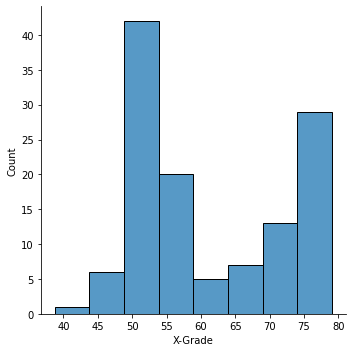

In [62]:
sns.displot(df_submit['X-Grade'])